<a href="https://colab.research.google.com/github/benjamin-du/all_things_trees/blob/main/2.%20Understand_how_trees_work_the_split_formula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

     |████████████████████████████████| 61kB 3.1MB/s 


In [4]:
from sklearn.datasets import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

We left off the first lesson with a question:

There is a variable on which making a split would perfectly separate the class "Edelweiss". Yet the model doesn't want to use that variable at first. Why is that ? 

To better understand this, let's force our model to pick that variable (we can do that by giving the model only this variable to make it's prediction):

In [5]:
# add the Edelweisses flowers to the iris dataset
iris_df = sns.load_dataset("iris")
edelweisses_df = iris_df.copy()
edelweisses_df['stem'] = np.random.rand(150) * 2
edelweisses_flowers = iris_df[ iris_df['species'] == "virginica"].sample(4).copy()
edelweisses_flowers['stem'] = 3.5
edelweisses_flowers['species'] = "Edelweiss"
edelweisses_df = edelweisses_df.append(edelweisses_flowers)
edelweisses_df = edelweisses_df[["sepal_length", "sepal_width", "petal_length", "petal_width", "stem", "species"]]

In [6]:
def make_classification_and_plot_tree(X_train, y_train, max_depth=1, min_samples_leaf=1):
    labels = y_train.unique().tolist()
    y_train = y_train.map({"setosa": 0, "versicolor":1, "virginica":2, "Edelweiss":3})

    clas = tree.DecisionTreeClassifier(max_depth=max_depth,
                                       min_samples_leaf=min_samples_leaf)  
    clas.fit(X_train.values, y_train)

    viz = dtreeviz(clas,
                   X_train,
                   y_train,
                   target_name='specie',
                   feature_names=X_train.columns.tolist(),
                   class_names=labels, 
                   histtype= 'barstacked',
                   show_node_labels= True,
                   scale=2.3)

    return viz

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


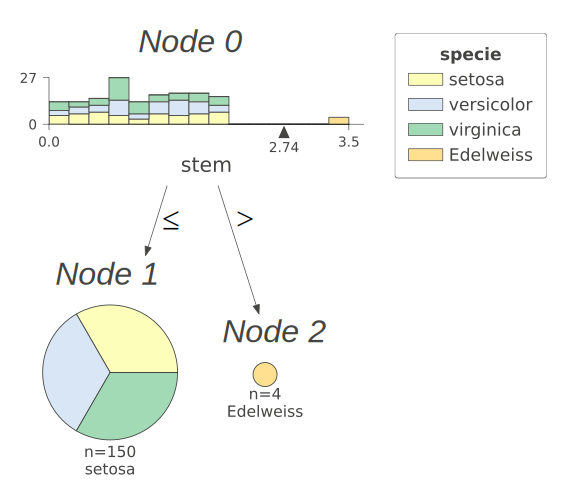

In [7]:
X_train = edelweisses_df.drop(["sepal_length", "sepal_width", "petal_length", "petal_width", "species"], axis=1)
y_train = edelweisses_df['species']

viz = make_classification_and_plot_tree(X_train, y_train)
viz

The problem we have is that, even though we now have a right node that's totally pure, we are still left with 150 over 154 examples to classify. So yes, we have a great right node.

But when making its decision, the tree also takes care of what happens in the other node !



---



<br /> 
Here is the mathematical formulation of the algorithm used by scikit-learn, as per the documentation:

<b> DON'T SWEAT THE MATH</b>, we'll break it down together !

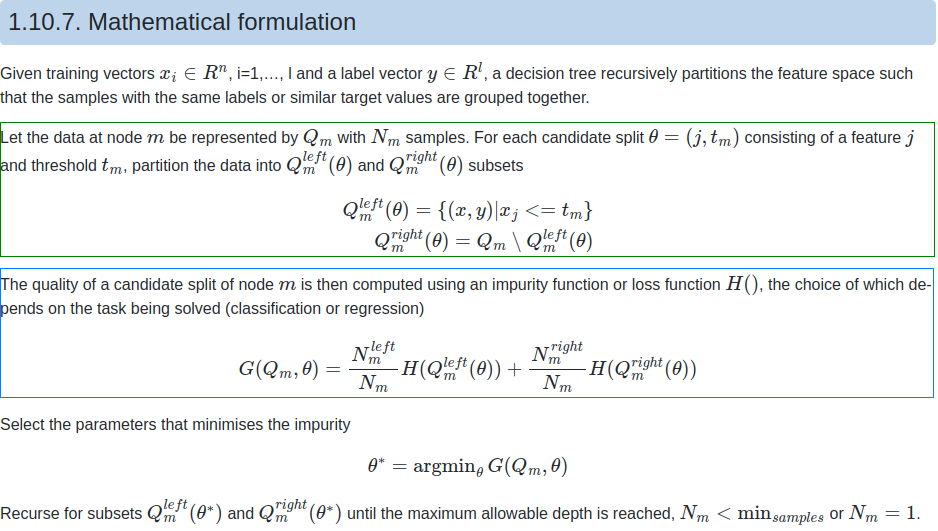

# Qm, Qleft_m and Qright_m... Heavy math notation for not much, really ;)

The first green rectangle might seem like a mouthful, but it's really not:

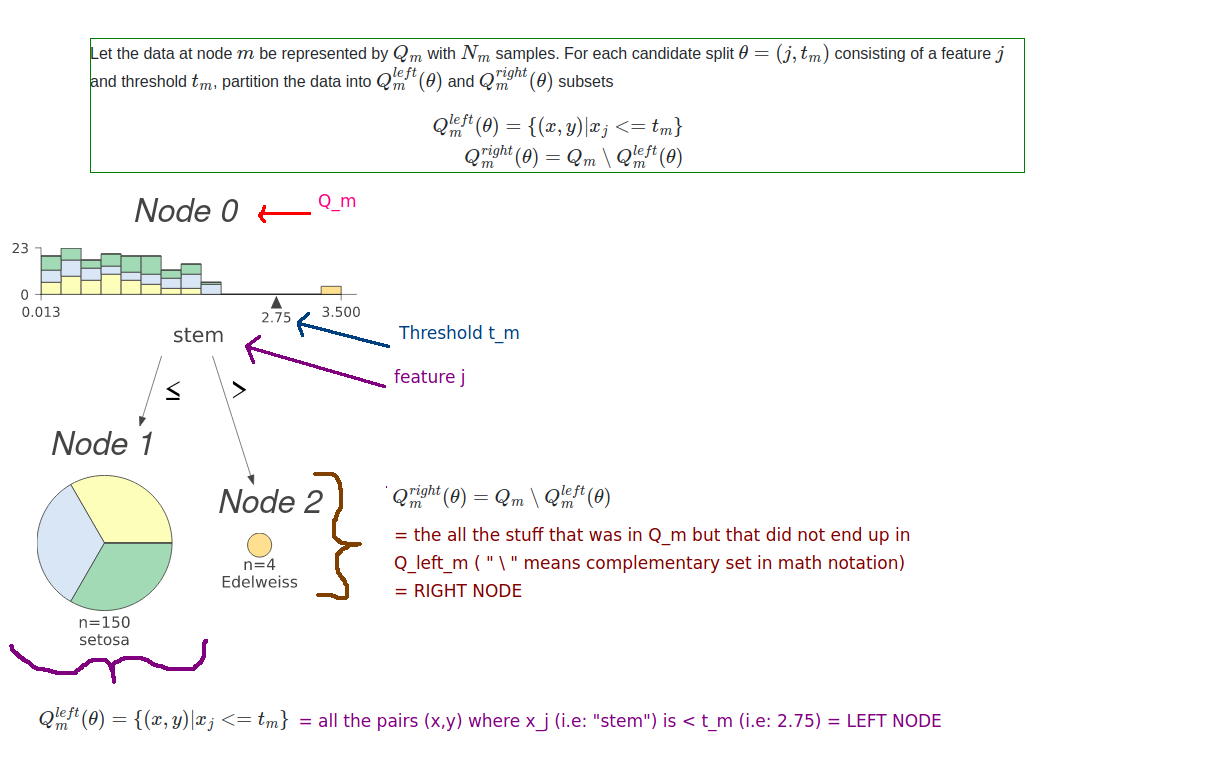

All you have to keep in mind is the following :
 - Q_left_m(Theta) and Q_right_m(Theta) just mean "The left split" and "The right split" of our current Node "m"

# G(Qm, THETA): the equation we want to minimize 

Let's now focus on the blue rectangle: 


- Nm is just the number of rows/observations/samples inside the Node.
- N_left_m is the number of rows that end up in the left split of the node
- N_right_m is the number of rows that end up in the right split of the node
- H() is the loss/cost function. We haven't defined it yet, but it doesn't matter for now.



The last part of the image tells us that our goal is to minimize G(Q_m, Theta).

If we plug the "english version" of our Edelweiss example into the fancy mathematical notation of the formula for G, we get this:


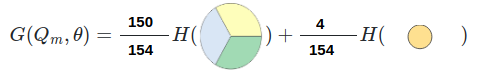

So it doesn't even matter right now _how_ we are going to calculate H(). We know our right node is pure so we'll have 0 on the right part of the equation. But we still get a left node that is:
1. as impure as it could be (we have three classes left, and they all amount for a third of the remaining data)
2. contains a lot of samples

As opposed to this example, if there were only 3 flowers (one of each specie) in the left Node, the left Node would:
1. be as impure as it could be (we have three classes left, and they all amount for a third of the remaining data)  << This doesn't change
2. contain only three samples << This DOES change.

In that case, we would have a big value for H(), but it would be multiplied by a very small number so G() would be small anyways.

If you have followed the code attentively in the previous notebook, you might have seen the following lines of code:

```
if not criterion:
    criterion = np.random.choice(["gini", "entropy"])
clas = tree.DecisionTreeClassifier(max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    criterion=criterion)
```
I did that in order to show that no matter which "formula" we picked for growing our tree, it would not pick "stem" as its first variable to make a split.
As "gini" is the default criterion, we'll start by explaining how it works. Here is the formula for Gini criterion:


In [ ]:
# Expliciter la DOC (paint) + Expliciter La fonction de coût 
# faire tous les splits possibles sur STEM et sur petal_length avec leurs coefficients de Gini